<a href="https://colab.research.google.com/github/zahranicp/hands-on-ML2/blob/main/chapter03/Chapter_3_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mengunduh data MNIST...
Data berhasil diunduh.
Bentuk X: (70000, 784)
Bentuk y: (70000,)


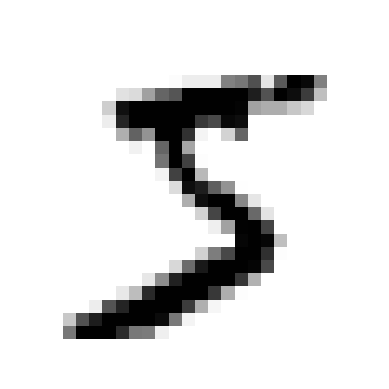

Label digit ini adalah: 5


In [ ]:
# Impor library
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml

# Mengambil data MNIST
# Butuh beberapa saat untuk mengunduh
print("Mengunduh data MNIST...")
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
print("Data berhasil diunduh.")

# Pisahkan fitur (X) dan label (y)
X, y = mnist["data"], mnist["target"]

# Lihat bentuk data
print(f"Bentuk X: {X.shape}")
print(f"Bentuk y: {y.shape}")

# Ubah tipe data label dari string ke integer
y = y.astype(np.uint8)

# Pisahkan data latih dan data uji
# MNIST sudah dipisah: 60,000 pertama untuk latih, 10,000 terakhir untuk uji
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# Ambil satu digit untuk pengujian
some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()
print(f"Label digit ini adalah: {y[0]}")

In [ ]:
from sklearn.linear_model import SGDClassifier

# Buat label target untuk "angka 5"
y_train_5 = (y_train == 5) # True untuk semua 5, False untuk lainnya
y_test_5 = (y_test == 5)

# Buat Stochastic Gradient Descent (SGD) classifier
# 'random_state' untuk hasil yang reproduktif
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

# Coba prediksi pada satu digit
print(f"Prediksi untuk 'some_digit' (angka 5): {sgd_clf.predict([some_digit])}")

Prediksi untuk 'some_digit' (angka 5): [ True]


In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.base import BaseEstimator

# Menggunakan cross_val_score untuk akurasi
print("Menghitung akurasi SGDClassifier...")
score = cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")
print(f"Akurasi Cross-Validation (3-fold): {score}")

# Membuat pengklasifikasi bodoh yang selalu memprediksi "bukan-5"
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

never_5_clf = Never5Classifier()
score_never_5 = cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")
print(f"Akurasi Never5Classifier: {score_never_5}")
print("Ini menunjukkan mengapa akurasi bisa menyesatkan pada skewed datasets.")

Menghitung akurasi SGDClassifier...
Akurasi Cross-Validation (3-fold): [0.95035 0.96035 0.9604 ]
Akurasi Never5Classifier: [0.91125 0.90855 0.90915]
Ini menunjukkan mengapa akurasi bisa menyesatkan pada skewed datasets.


In [ ]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

# Dapatkan prediksi dari cross-validation
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

# Buat confusion matrix
cm = confusion_matrix(y_train_5, y_train_pred)
print("Confusion Matrix:")
print(cm)
# Baris: Kelas Aktual (0: Bukan-5, 1: Angka 5)
# Kolom: Kelas Prediksi (0: Bukan-5, 1: Angka 5)
# [True Negative, False Positive]
# [False Negative, True Positive]

Confusion Matrix:
[[53892   687]
 [ 1891  3530]]


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Hitung precision dan recall dari confusion matrix
# Presisi = TP / (TP + FP)
# Recall = TP / (TP + FN)

precision = precision_score(y_train_5, y_train_pred)
recall = recall_score(y_train_5, y_train_pred)
f1 = f1_score(y_train_5, y_train_pred)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Precision: 0.8371
Recall: 0.6512
F1 Score: 0.7325


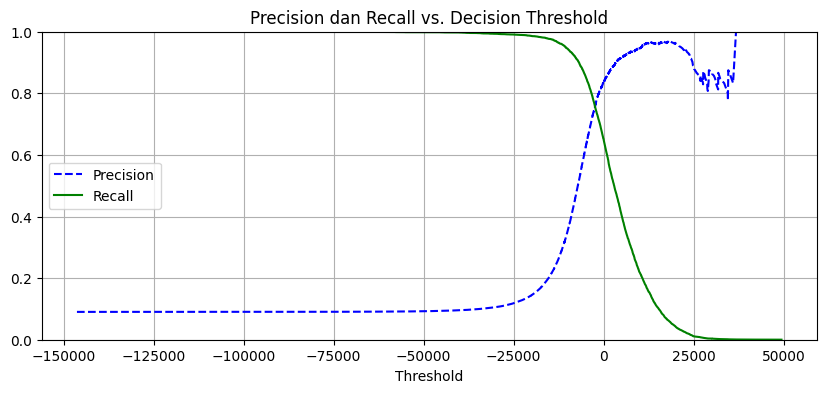

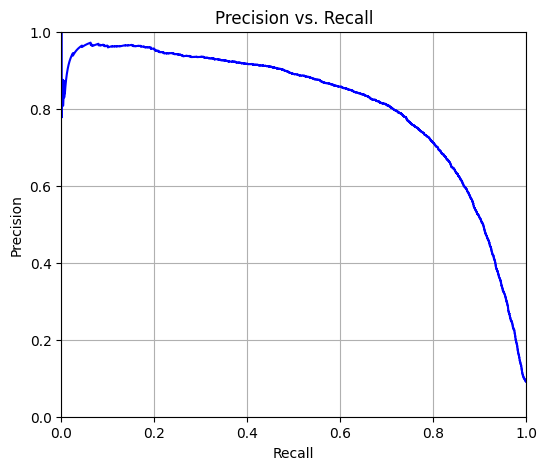

In [ ]:
from sklearn.metrics import precision_recall_curve

# Dapatkan skor keputusan (decision scores)
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

# Hitung precision dan recall untuk semua threshold
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

# Fungsi untuk plotting
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="center left")
    plt.grid(True)
    plt.title("Precision dan Recall vs. Decision Threshold")
    plt.ylim([0, 1])

plt.figure(figsize=(10, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

# Plot Precision vs Recall (Kurva PR)
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.grid(True)
    plt.title("Precision vs. Recall")
    plt.axis([0, 1, 0, 1])

plt.figure(figsize=(6, 5))
plot_precision_vs_recall(precisions, recalls)
plt.show()

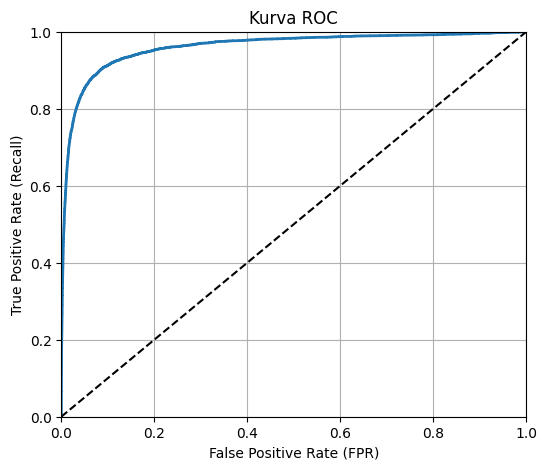

ROC AUC Score (SGD): 0.9605


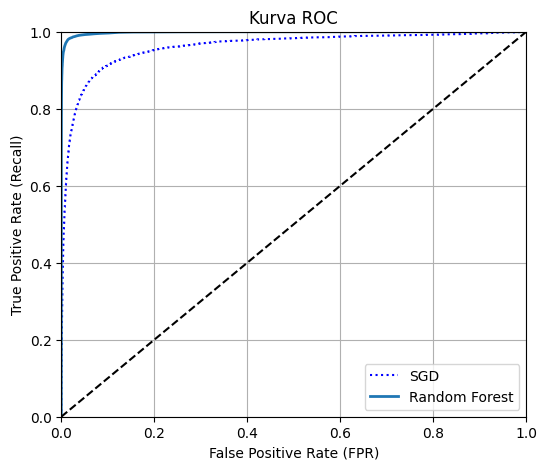

ROC AUC Score (Random Forest): 0.9983


In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier

# Hitung FPR dan TPR
fpr, tpr, thresholds_roc = roc_curve(y_train_5, y_scores)

# Fungsi untuk plotting
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # Garis diagonal (pengklasifikasi acak)
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (Recall)')
    plt.grid(True)
    plt.title('Kurva ROC')
    plt.axis([0, 1, 0, 1])

plt.figure(figsize=(6, 5))
plot_roc_curve(fpr, tpr)
plt.show()

# Hitung Area Under the Curve (AUC)
auc = roc_auc_score(y_train_5, y_scores)
print(f"ROC AUC Score (SGD): {auc:.4f}")

# Bandingkan dengan RandomForest
forest_clf = RandomForestClassifier(random_state=42)
# predict_proba dibutuhkan untuk skor ROC
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

# Skor untuk kurva ROC adalah probabilitas kelas positif
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

# Plot perbandingan
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

auc_forest = roc_auc_score(y_train_5, y_scores_forest)
print(f"ROC AUC Score (Random Forest): {auc_forest:.4f}")

In [ ]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

# Melatih SVM (otomatis menggunakan One-vs-One)
svm_clf = SVC()
svm_clf.fit(X_train, y_train) # Gunakan y_train, bukan y_train_5
print(f"Prediksi SVM pada 'some_digit': {svm_clf.predict([some_digit])}")

# Lihat skor decision_function (10 skor, satu per kelas)
some_digit_scores = svm_clf.decision_function([some_digit])
print("Skor SVM (OvO):")
print(some_digit_scores)
print(f"Kelas yang diprediksi: {np.argmax(some_digit_scores)}")

# Melatih SGDClassifier (dapat menangani multikelas secara langsung)
sgd_clf.fit(X_train, y_train)
print(f"Prediksi SGD pada 'some_digit': {sgd_clf.predict([some_digit])}")

# Evaluasi SGD dengan scaling
print("Mengevaluasi SGDClassifier (multikelas)...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
score_sgd = cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")
print(f"Akurasi SGD (setelah scaling): {score_sgd}")

Prediksi SVM pada 'some_digit': [5]
Skor SVM (OvO):
[[ 1.72501977  2.72809088  7.2510018   8.3076379  -0.31087254  9.3132482
   1.70975103  2.76765202  6.23049537  4.84771048]]
Kelas yang diprediksi: 5
Prediksi SGD pada 'some_digit': [3]
Mengevaluasi SGDClassifier (multikelas)...
Akurasi SGD (setelah scaling): [0.8983 0.891  0.9018]


Confusion Matrix (Multikelas):
[[5577    0   22    5    8   43   36    6  225    1]
 [   0 6400   37   24    4   44    4    7  212   10]
 [  27   27 5220   92   73   27   67   36  378   11]
 [  22   17  117 5227    2  203   27   40  403   73]
 [  12   14   41    9 5182   12   34   27  347  164]
 [  27   15   30  168   53 4444   75   14  535   60]
 [  30   15   42    3   44   97 5552    3  131    1]
 [  21   10   51   30   49   12    3 5684  195  210]
 [  17   63   48   86    3  126   25   10 5429   44]
 [  25   18   30   64  118   36    1  179  371 5107]]


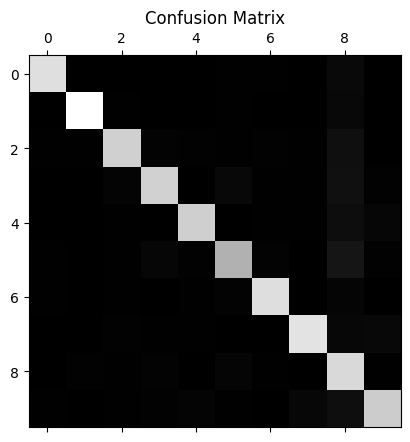

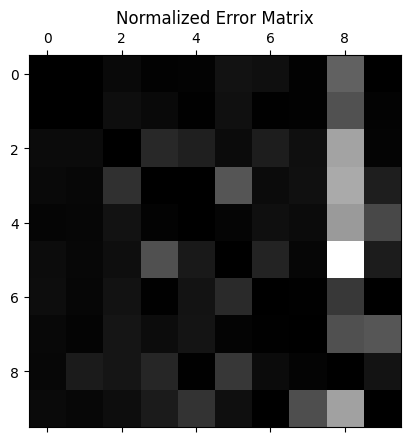

In [ ]:
# Dapatkan prediksi multikelas
y_train_pred_multi = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)

# Buat confusion matrix
conf_mx = confusion_matrix(y_train, y_train_pred_multi)
print("Confusion Matrix (Multikelas):")
print(conf_mx)

# Plot confusion matrix sebagai gambar
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.title("Confusion Matrix")
plt.show()

# Plot matriks kesalahan (fokus pada error)
# Bagi setiap nilai dengan jumlah gambar di kelas aktual
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

# Isi diagonal dengan 0 untuk fokus pada kesalahan
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.title("Normalized Error Matrix")
plt.show()
# Baris terang = kelas aktual yang sering salah
# Kolom terang = kelas yang sering salah diprediksi

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# Buat dua label untuk setiap instans:
# 1. Apakah digitnya besar (7, 8, atau 9)?
y_train_large = (y_train >= 7)
# 2. Apakah digitnya ganjil?
y_train_odd = (y_train % 2 == 1)

# Gabungkan label
y_multilabel = np.c_[y_train_large, y_train_odd]

# Latih K-Nearest Neighbors classifier
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

print(f"Prediksi multilabel pada 'some_digit' (angka 5): {knn_clf.predict([some_digit])}")
# Output: [[False, True]] -> Bukan angka besar, dan Ganjil. (Benar!)

# Evaluasi Multilabel (contoh: F1 score rata-rata)
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_macro = f1_score(y_multilabel, y_train_knn_pred, average="macro")
print(f"F1 Score (Macro Average): {f1_macro:.4f}")

Prediksi multilabel pada 'some_digit' (angka 5): [[False  True]]
F1 Score (Macro Average): 0.9764


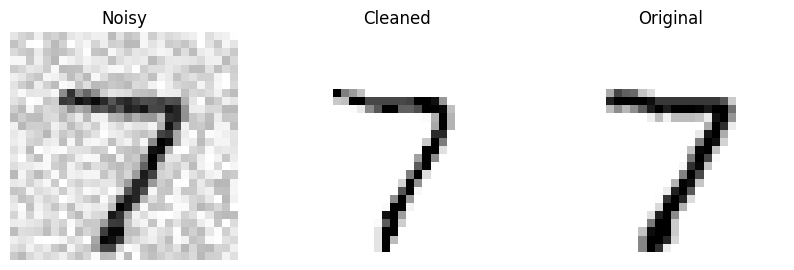

In [ ]:
# Tambahkan noise ke gambar MNIST
noise_train = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise_train
noise_test = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise_test

# Targetnya adalah gambar asli (bersih)
y_train_mod = X_train
y_test_mod = X_test

# Latih classifier untuk membersihkan gambar
knn_clf_denoise = KNeighborsClassifier() # Buat instance baru
knn_clf_denoise.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf_denoise.predict([X_test_mod[0]])

# Tampilkan gambar asli, gambar bernoise, dan gambar bersih
def plot_digit(data, label):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap="binary")
    plt.axis("off")
    plt.title(label)

plt.figure(figsize=(10, 4))
plt.subplot(131); plot_digit(X_test_mod[0], "Noisy")
plt.subplot(132); plot_digit(clean_digit, "Cleaned")
plt.subplot(133); plot_digit(y_test_mod[0], "Original")
plt.show()

**Bab 3: Klasifikasi**

**1. Persiapan Awal**

Kita mulai dengan mengimpor library yang dibutuhkan dan memuat dataset MNIST. MNIST adalah dataset klasik dalam Machine Learning, berisi 70.000 gambar angka tulisan tangan berukuran 28x28 piksel. Dataset ini sering dijadikan contoh dasar untuk memahami klasifikasi.

**Penjelasan Teoretis:**

* fetch_openml: Fungsi dari Scikit-Learn ini digunakan untuk mengunduh dataset langsung dari repositori openml.org.

* Pemisahan Fitur (X) dan Label (y): X berisi data yang digunakan model untuk belajar (dalam hal ini, setiap gambar direpresentasikan sebagai 784 piksel), sedangkan y adalah target yang ingin diprediksi (angka 0–9).

* Konversi Tipe Data Label: Label awalnya berbentuk string (misal "5"), sehingga perlu dikonversi ke tipe numerik (np.uint8) agar algoritma ML dapat memprosesnya dengan optimal.

* Pemisahan Data Train/Test: Data dibagi menjadi set pelatihan (X_train, y_train) yang digunakan model untuk belajar, dan set pengujian (X_test, y_test) yang hanya digunakan di akhir untuk mengevaluasi kemampuan model dalam mengenali data baru yang belum pernah dilihat.

### 2. Melatih Pengklasifikasi Biner (Binary Classifier)

Sebelum menangani 10 digit sekaligus (klasifikasi *multikelas*), kita akan menyederhanakan masalah ini menjadi klasifikasi *biner*: "angka 5" atau "bukan angka 5".

**Penjelasan Teoretis:**
* **Target Biner**: Kita membuat variabel target baru (`y_train_5` dan `y_test_5`) yang bernilai `True` jika digitnya 5, dan `False` untuk semua digit lainnya. Ini mengubah masalah dari 10 kelas menjadi 2 kelas.
* **`SGDClassifier` (Stochastic Gradient Descent)**: Ini adalah model pengklasifikasi linear yang sangat efisien untuk dataset besar. "Stochastic" (acak) berarti ia memproses data latih dalam *batch* kecil (atau bahkan satu per satu) di setiap langkah, membuatnya lebih cepat daripada algoritma yang harus memuat seluruh data sekaligus. Ini adalah pilihan dasar yang baik untuk memulai.

### 3. Mengukur Kinerja Model

Bagian ini adalah inti dari bab ini. Kita akan belajar mengapa "akurasi" saja tidak cukup dan bagaimana cara mengevaluasi model klasifikasi dengan benar.

#### a. Akurasi dan Jebakan Dataset Miring (Skewed Dataset)

**Penjelasan Teoretis:**
* **`cross_val_score`**: Metode ini melakukan *K-fold Cross-Validation*. Alih-alih hanya membagi data latih satu kali, metode ini membaginya menjadi `cv=3` bagian (fold). Ia melatih model 3 kali, setiap kali menggunakan 2 bagian untuk melatih dan 1 bagian untuk validasi. Ini memberikan ukuran kinerja yang jauh lebih stabil daripada satu kali pemisahan train/validation.
* **Dataset Miring (Skewed Dataset)**: Dataset kita "miring" karena hanya sekitar 10% gambar adalah angka 5, dan 90% sisanya adalah "bukan-5".
* **`Never5Classifier`**: Ini adalah pengklasifikasi "bodoh" yang kita buat untuk membuktikan suatu poin. Jika Anda selalu menebak "bukan-5", Anda akan benar 90% dari waktu! Akurasi 90% terdengar luar biasa, tetapi model ini sama sekali tidak berguna karena tidak pernah mendeteksi kelas yang kita cari. Ini membuktikan bahwa **akurasi adalah metrik yang buruk untuk dataset miring**.

#### b. Confusion Matrix (Matriks Kebingungan)

Cara yang jauh lebih baik untuk mengevaluasi kinerja adalah dengan melihat jumlah prediksi yang benar dan yang salah secara spesifik.

**Penjelasan Teoretis:**
* **`cross_val_predict`**: Ini mirip dengan `cross_val_score`, tetapi alih-alih mengembalikan skor, ia mengembalikan prediksi "bersih" (clean predictions) untuk setiap instans di data latih. "Bersih" berarti prediksi untuk setiap instans dibuat oleh model yang dilatih *tanpa* pernah melihat instans tersebut.
* **Membaca Confusion Matrix**:
    * **Baris**: Kelas *aktual* (kenyataan).
    * **Kolom**: Kelas *prediksi* (tebakan model).
* **Istilah Penting**:
    * **True Negative (TN)**: Kiri atas. Model menebak "bukan-5", dan itu benar.
    * **False Positive (FP)**: Kanan atas. Model menebak "5", padahal *bukan* (Tipe I Error).
    * **False Negative (FN)**: Kiri bawah. Model menebak "bukan-5", padahal itu *angka 5* (Tipe II Error).
    * **True Positive (TP)**: Kanan bawah. Model menebak "5", dan itu benar.

#### c. Precision, Recall, dan F1-Score

Dari Confusion Matrix, kita mendapatkan metrik yang jauh lebih berguna.

**Penjelasan Teoretis:**
* **Precision (Presisi)**: $Precision = \frac{TP}{TP + FP}$
    * **Pertanyaan yang Dijawab**: "Dari semua instans yang *diprediksi* model sebagai positif (angka 5), berapa banyak yang benar-benar positif?"
    * Ini adalah metrik untuk *akurasi prediksi positif*. Presisi tinggi penting ketika *False Positive* sangat merugikan (misal: mengklasifikasikan email penting sebagai spam).

* **Recall (Perolehan)**: $Recall = \frac{TP}{TP + FN}$
    * **Pertanyaan yang Dijawab**: "Dari semua instans yang *sebenarnya* positif (semua angka 5 asli), berapa banyak yang berhasil *dideteksi* model?"
    * Disebut juga *sensitivitas* atau *True Positive Rate (TPR)*. Recall tinggi penting ketika *False Negative* sangat merugikan (misal: gagal mendeteksi tumor ganas).

* **F1-Score**: $F_1 = 2 \times \frac{Precision \times Recall}{Precision + Recall}$
    * **Penjelasan**: Ini adalah **rata-rata harmonik** dari presisi dan recall. Tidak seperti rata-rata biasa, rata-rata harmonik memberi bobot lebih besar pada nilai yang rendah.
    * **Akibatnya**: Model hanya akan mendapatkan F1-Score tinggi jika *kedua* metrik (presisi dan recall) tinggi. Ini adalah cara yang baik untuk menyeimbangkan kedua metrik tersebut menjadi satu angka.

#### d. Trade-off Precision/Recall dan Kurva

Anda tidak bisa mendapatkan keduanya. Meningkatkan presisi seringkali menurunkan recall, dan sebaliknya. Ini disebut **Trade-off Precision/Recall**.

**Penjelasan Teoretis:**
* **Decision Function & Threshold**: `SGDClassifier` tidak hanya menebak Ya/Tidak. Ia menghitung *skor* untuk setiap instans menggunakan `decision_function`.
    * Jika `skor > threshold` (nilai ambang), ia memprediksi positif.
    * Jika `skor < threshold`, ia memprediksi negatif.
* **Bagaimana Trade-off Terjadi**:
    * **Menaikkan Threshold**: Model menjadi lebih "pilih-pilih". Ia hanya akan memprediksi '5' jika sangat yakin. Ini akan mengurangi *False Positive* (meningkatkan presisi), tetapi akan melewatkan banyak angka 5 yang "mirip" (mengurangi recall).
    * **Menurunkan Threshold**: Model menjadi lebih "longgar". Ia akan memprediksi '5' bahkan jika tidak terlalu yakin. Ini akan menangkap lebih banyak angka 5 (meningkatkan recall), tetapi juga akan salah mengklasifikasikan angka lain sebagai 5 (menurunkan presisi).
* **Kurva PR**: Plot `plot_precision_recall_vs_threshold` menunjukkan trade-off ini. Anda dapat memilih *threshold* yang memberikan keseimbangan terbaik untuk kasus penggunaan Anda. Plot `plot_precision_vs_recall` menunjukkan trade-off ini secara langsung (idealnya, kurva ada di pojok kanan atas).

#### e. Kurva ROC (Receiver Operating Characteristic)

Kurva ROC adalah alat evaluasi umum lainnya untuk pengklasifikasi biner.

**Penjelasan Teoretis:**
* **Sumbu Kurva**: Kurva ROC memplot **True Positive Rate (Recall)** (sensitivitas) melawan **False Positive Rate (FPR)** (1 - spesifisitas).
    * **TPR (Recall)**: Seberapa baik model mendeteksi kelas positif.
    * **FPR**: Rasio instans negatif yang salah diklasifikasikan sebagai positif. $FPR = \frac{FP}{FP + TN}$.
* **Cara Membaca Kurva**:
    * **Pojok Kiri Atas**: Pengklasifikasi sempurna (TPR=1, FPR=0).
    * **Garis Diagonal (k-- 'k--')**: Pengklasifikasi acak (random). Model Anda harus berada sejauh mungkin di atas garis ini.
* **AUC (Area Under the Curve)**: Adalah ukuran kinerja tunggal yang dihitung dari kurva ROC.
    * AUC = 1.0: Pengklasifikasi sempurna.
    * AUC = 0.5: Pengklasifikasi acak (tidak berguna).
* **Kapan Digunakan?**:
    * Gunakan **Kurva ROC / AUC** saat kedua kelas (positif dan negatif) sama-sama penting atau saat dataset seimbang.
    * Gunakan **Kurva PR** saat kelas positif jarang (skewed) atau saat Anda lebih peduli pada *False Positive* daripada *False Negative*.
* **Perbandingan Model**: Kita juga melatih `RandomForestClassifier`. Dengan memplot kedua kurva ROC pada grafik yang sama, kita dapat melihat secara visual bahwa kurva Random Forest jauh lebih baik (lebih dekat ke pojok kiri atas) dan memiliki AUC yang lebih tinggi.

### 4. Klasifikasi Multikelas (Multiclass Classification)

Sekarang kita beralih dari deteksi "5 vs bukan-5" ke pengenalan semua 10 digit (0-9).

**Penjelasan Teoretis:**
* Beberapa algoritma (seperti `SGDClassifier`, `RandomForestClassifier`) dapat menangani banyak kelas secara langsung (disebut *native multiclass*).
* Algoritma lain (seperti `SVC` atau `LogisticRegression`) pada dasarnya adalah pengklasifikasi biner. Ketika digunakan untuk tugas multikelas, mereka secara otomatis menggunakan salah satu dari dua strategi:
    1.  **One-vs-Rest (OvR) / One-vs-All (OvA)**: Melatih 10 pengklasifikasi biner (satu per digit: "0 vs bukan-0", "1 vs bukan-1", dst.). Untuk memprediksi, ambil skor dari semua 10 pengklasifikasi dan pilih kelas dengan skor tertinggi.
    2.  **One-vs-One (OvO)**: Melatih pengklasifikasi biner untuk setiap *pasangan* digit (misal: "0 vs 1", "0 vs 2", "1 vs 2", ..., "8 vs 9"). Ini menghasilkan N * (N-1) / 2 pengklasifikasi (ada 45 untuk MNIST). Untuk memprediksi, jalankan instans melalui semua 45 pengklasifikasi dan lihat kelas mana yang paling banyak "menang" dalam duel.
* **Pilihan Scikit-Learn**: `SVC` menggunakan strategi **OvO** karena lebih efisien untuk SVM. `SGDClassifier` menggunakan **OvR**.
* **Scaling (Penskalaan)**: `StandardScaler` sangat penting untuk `SGDClassifier`. Model ini sangat sensitif terhadap skala fitur. Tanpa penskalaan, kinerjanya akan buruk. `SVC` juga mendapat manfaat dari penskalaan.

### 5. Analisis Kesalahan (Error Analysis)

Setelah memiliki model multikelas, kita tidak hanya melihat skor akurasi. Kita perlu melihat *jenis kesalahan* apa yang dibuatnya.

**Penjelasan Teoretis:**
* **Tujuan**: Menemukan pola dalam kesalahan. Apakah model bingung antara '5' dan '3'? Apakah ia bingung antara '8' dan '9'?
* **Confusion Matrix (Lagi)**: Seperti sebelumnya, baris adalah kelas *aktual* dan kolom adalah kelas *prediksi*. Untuk model multikelas yang baik, sebagian besar gambar akan berada di *diagonal utama* (di mana prediksi == aktual).
* **Plotting `plt.matshow`**: Visualisasi matriks sangat membantu.
    * Plot pertama (skala abu-abu) menunjukkan jumlah absolut. Diagonal yang terang berarti banyak prediksi benar.
* **Normalisasi (Plot Kedua)**: Plot pertama bisa menyesatkan jika jumlah gambar per kelas tidak sama. Kita menormalisasi matriks dengan membagi setiap nilai dengan jumlah total gambar di *kelas aktualnya* (jumlah per baris).
    * **Cara Membaca Plot Error yang Dinormalisasi**:
        * Kita mengisi diagonal dengan 0 agar kita *hanya* fokus pada kesalahan.
        * **Baris Terang**: Menunjukkan kelas *aktual* yang sering salah diklasifikasikan. (Misal: jika baris 5 terang, itu berarti angka '5' sering salah diprediksi sebagai angka lain).
        * **Kolom Terang**: Menunjukkan kelas *prediksi* yang sering salah. (Misal: jika kolom 8 terang, itu berarti banyak angka lain yang salah diprediksi *sebagai* '8').

### 6. Klasifikasi Multilabel (Multilabel Classification)

Bagaimana jika setiap instans dapat memiliki *beberapa* label sekaligus?

**Penjelasan Teoretis:**
* **Multiclass vs. Multilabel**:
    * **Multiclass**: Satu instans, satu label dari banyak pilihan (misal: gambar ini adalah '3').
    * **Multilabel**: Satu instans, bisa memiliki *beberapa* label biner (misal: email ini adalah 'penting' DAN 'spam').
* **Penerapan**: Kita membuat dua label target: `y_train_large` (apakah digit >= 7?) dan `y_train_odd` (apakah digit ganjil?).
* **`KNeighborsClassifier`**: Algoritma ini secara alami mendukung klasifikasi multilabel. Ia akan menemukan tetangga terdekat dan mengeluarkan label mayoritas untuk *setiap* tugas.
* **Evaluasi (`average="macro"`)**: Ini adalah cara umum untuk mengevaluasi pengklasifikasi multilabel. Ini menghitung F1-score untuk setiap label secara independen, lalu mengambil rata-rata (tanpa pembobotan).

### 7. Klasifikasi *Multioutput (Multioutput Classification)*

Ini adalah generalisasi dari klasifikasi multilabel, di mana setiap label bisa *multikelas* (bukan hanya biner).

**Penjelasan Teoretis:**
* **Contoh Denoising**: Kita akan menggunakan model untuk membersihkan gambar yang bernoise.
    * **Input (`X_train_mod`)**: Gambar 784 piksel yang telah ditambahi noise acak.
    * **Output (`y_train_mod`)**: Gambar 784 piksel yang asli (bersih).
* **Mengapa ini Multioutput-Multiclass?**:
    * Ini **multioutput** karena model harus memprediksi 784 nilai (satu untuk setiap piksel).
    * Ini (secara teknis) **multikelas** karena setiap label (piksel) dapat memiliki nilai antara 0-255.
* `KNeighborsClassifier` *italicized text* juga dapat menangani ini, meskipun ini adalah penggunaan yang tidak biasa. Ia akan menemukan gambar-gambar bernoise di set latih yang paling mirip, dan kemudian memprediksi gambar bersihnya dengan mengambil rata-rata (atau mayoritas) dari target-target bersih yang sesuai. Hasilnya adalah rekonstruksi gambar yang telah dibersihkan.